In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

from tools_ryu import mytool
from multi_run.initialize_v2 import data_pp, make_market_index
from multi_run.momentum_strategy import *

2023-05-12 10:03:51,435	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-12 10:03:54,971	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [2]:
# Binance Data는 코드 수정해야함
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
#cmktcap_reduced = pd.read_pickle("Data/cmktcap_data_reduced.pickle")
#binance = pd.read_pickle("Data/binance_data_pp.pickle")

In [3]:
#값들 설정          mktcap, volume
group_value = {"M0":[1_000_000, None],
               "M1":[1_000_000,1_000_000],
               "M2":[1_000_000,5_000_000]}

In [4]:
# Initialize the Data
cmkt_data = data_pp(cmktcap, vender="coinmarketcap")
#cmktre_data = data_pp(cmktcap_reduced, vender="coinmarketcap")
#binance_data = data_pp(binance, vender="binance")

In [5]:
# Ray Data 생성
ray_price = ray.put(cmkt_data["price"])
ray_mktcap = ray.put(cmkt_data["mktcap"])
ray_vol = ray.put(cmkt_data["vol"])

# Binance Data 생성
#ray_price_b = ray.put(binance_data["price"])
#ray_mktcap_b = ray.put(binance_data["mktcap"])
#ray_vol_b = ray.put(binance_data["vol"])

In [6]:
days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [ ]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)

In [ ]:
# Ray Data 생성
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

# 1. Market Index 생성

In [ ]:
# 코인 마켓 인덱스 생성  리턴값 -> mkt_index, time_series_coin_num
market_index_cmkt = {}

mkt_future = [make_market_index.remote(price_df=ray_price,
                                       mktcap_df=ray_mktcap,
                                       vol_df=ray_vol,
                                       mktcap_thresh=value_lst[0],
                                       vol_thresh=value_lst[1]) 
              for key, value_lst in group_value.items()]

mkt_result = ray.get(mkt_future)

In [ ]:
mkt_result_dict = {"M0":mkt_result[0],
                   "M1":mkt_result[1],
                   "M2":mkt_result[2],}
                   #"M4":mkt_result[3]}

In [ ]:
mytool.draw_return_result(mkt_result_dict, 
                          title="",
                          log=False)

In [ ]:
mkt_result_dict["M2"]

In [ ]:
mytool.print_statistics(mkt_result_dict)

# 2. 모멘텀 전략 (Value Weighted)

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                         mktcap_df=ray_mktcap,
                                                         vol_df=ray_vol,
                                                         n_group=5,
                                                         day_of_week=day,
                                                         number_of_coin_group=20,
                                                         mktcap_thresh=1_000_000,
                                                         vol_thresh=5_000_000,
                                                         fee_rate=0.0015) 
              for day in days_lst]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"MON":momentum_result[0],
                        "TUE":momentum_result[1],
                        "WED":momentum_result[2],
                        "THU":momentum_result[3],
                        "FRI":momentum_result[4],
                        "SAT":momentum_result[5],
                        "SUN":momentum_result[6],}

In [ ]:
ls = {"MON":momentum_result_dict["MON"]["Long_Q5"],
 "TUE":momentum_result_dict["TUE"]["Long_Q5"],
 "WED":momentum_result_dict["WED"]["Long_Q5"],
 "THU":momentum_result_dict["THU"]["Long_Q5"],
 "FRI":momentum_result_dict["FRI"]["Long_Q5"],
 "SAT":momentum_result_dict["SAT"]["Long_Q5"],
 "SUN":momentum_result_dict["SUN"]["Long_Q5"],}

mytool.print_statistics(ls)

In [ ]:
mytool.draw_return_result(ls, title="Long_Q5 Result M2", log=True,
                          one_plot=True)

Binance

In [ ]:
# Binance Data
momentum_binance = {}
momentum_future_binance = [weekly_momentum_value_weighted.remote(price_df=ray_price_b,
                                                                 mktcap_df=ray_mktcap_b,
                                                                 vol_df=ray_vol_b,
                                                                 n_group=4,
                                                                 day_of_week="SUN",
                                                                 number_of_coin_group=10,
                                                                 mktcap_thresh=value_lst[0],
                                                                 vol_thresh=value_lst[1],
                                                                 fee_rate=0.0015) 
                          for key, value_lst in group_value.items()]

momentum_result_b = ray.get(momentum_future_binance)

In [ ]:
momentum_result_dict_b = {"M0":momentum_result_b[0],
                        "M1":momentum_result_b[1],
                        "M2":momentum_result_b[2]}

In [ ]:
mytool.draw_return_result(momentum_result_dict_b["M1"], 
                          title="",
                          log=False)

# 3. Value Weighted, Marketcap Capped 

In [7]:
days_lst

['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

In [31]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                         mktcap_df=ray_mktcap,
                                                         vol_df=ray_vol,
                                                         n_group=5,
                                                         day_of_week=day,
                                                         number_of_coin_group=20,
                                                         mktcap_thresh=1_000_000,
                                                         vol_thresh=5_000_000,
                                                         fee_rate=0.0015,
                                                         num_cap=5) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [32]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                        "TUE":momentum_capped_result[1],
                        "WED":momentum_capped_result[2],
                        "THU":momentum_capped_result[3],
                        "FRI":momentum_capped_result[4],
                        "SAT":momentum_capped_result[5],
                        "SUN":momentum_capped_result[6],}

In [37]:
what = "LongQ5"

ls = {"MON":momentum_result_dict_c["MON"][what],
 "TUE":momentum_result_dict_c["TUE"][what],
 "WED":momentum_result_dict_c["WED"][what],
 "THU":momentum_result_dict_c["THU"][what],
 "FRI":momentum_result_dict_c["FRI"][what],
 "SAT":momentum_result_dict_c["SAT"][what],
 "SUN":momentum_result_dict_c["SUN"][what],}

mytool.print_statistics(ls)

,MON,TUE,WED,THU,FRI,SAT,SUN
CAGR,-0.062500,-0.131000,-0.093500,-0.192000,-0.141500,-0.252300,-0.084800
Mean,0.425980,0.311950,0.350590,0.274660,0.288910,0.215870,0.406460
STD,0.981246,0.950172,0.941265,0.979221,0.942481,0.963010,0.965993
MDD,0.952000,0.979000,0.958000,0.962000,0.948000,0.960000,0.942000
Sharpe,0.434121,0.328309,0.372467,0.280488,0.306542,0.224162,0.420769


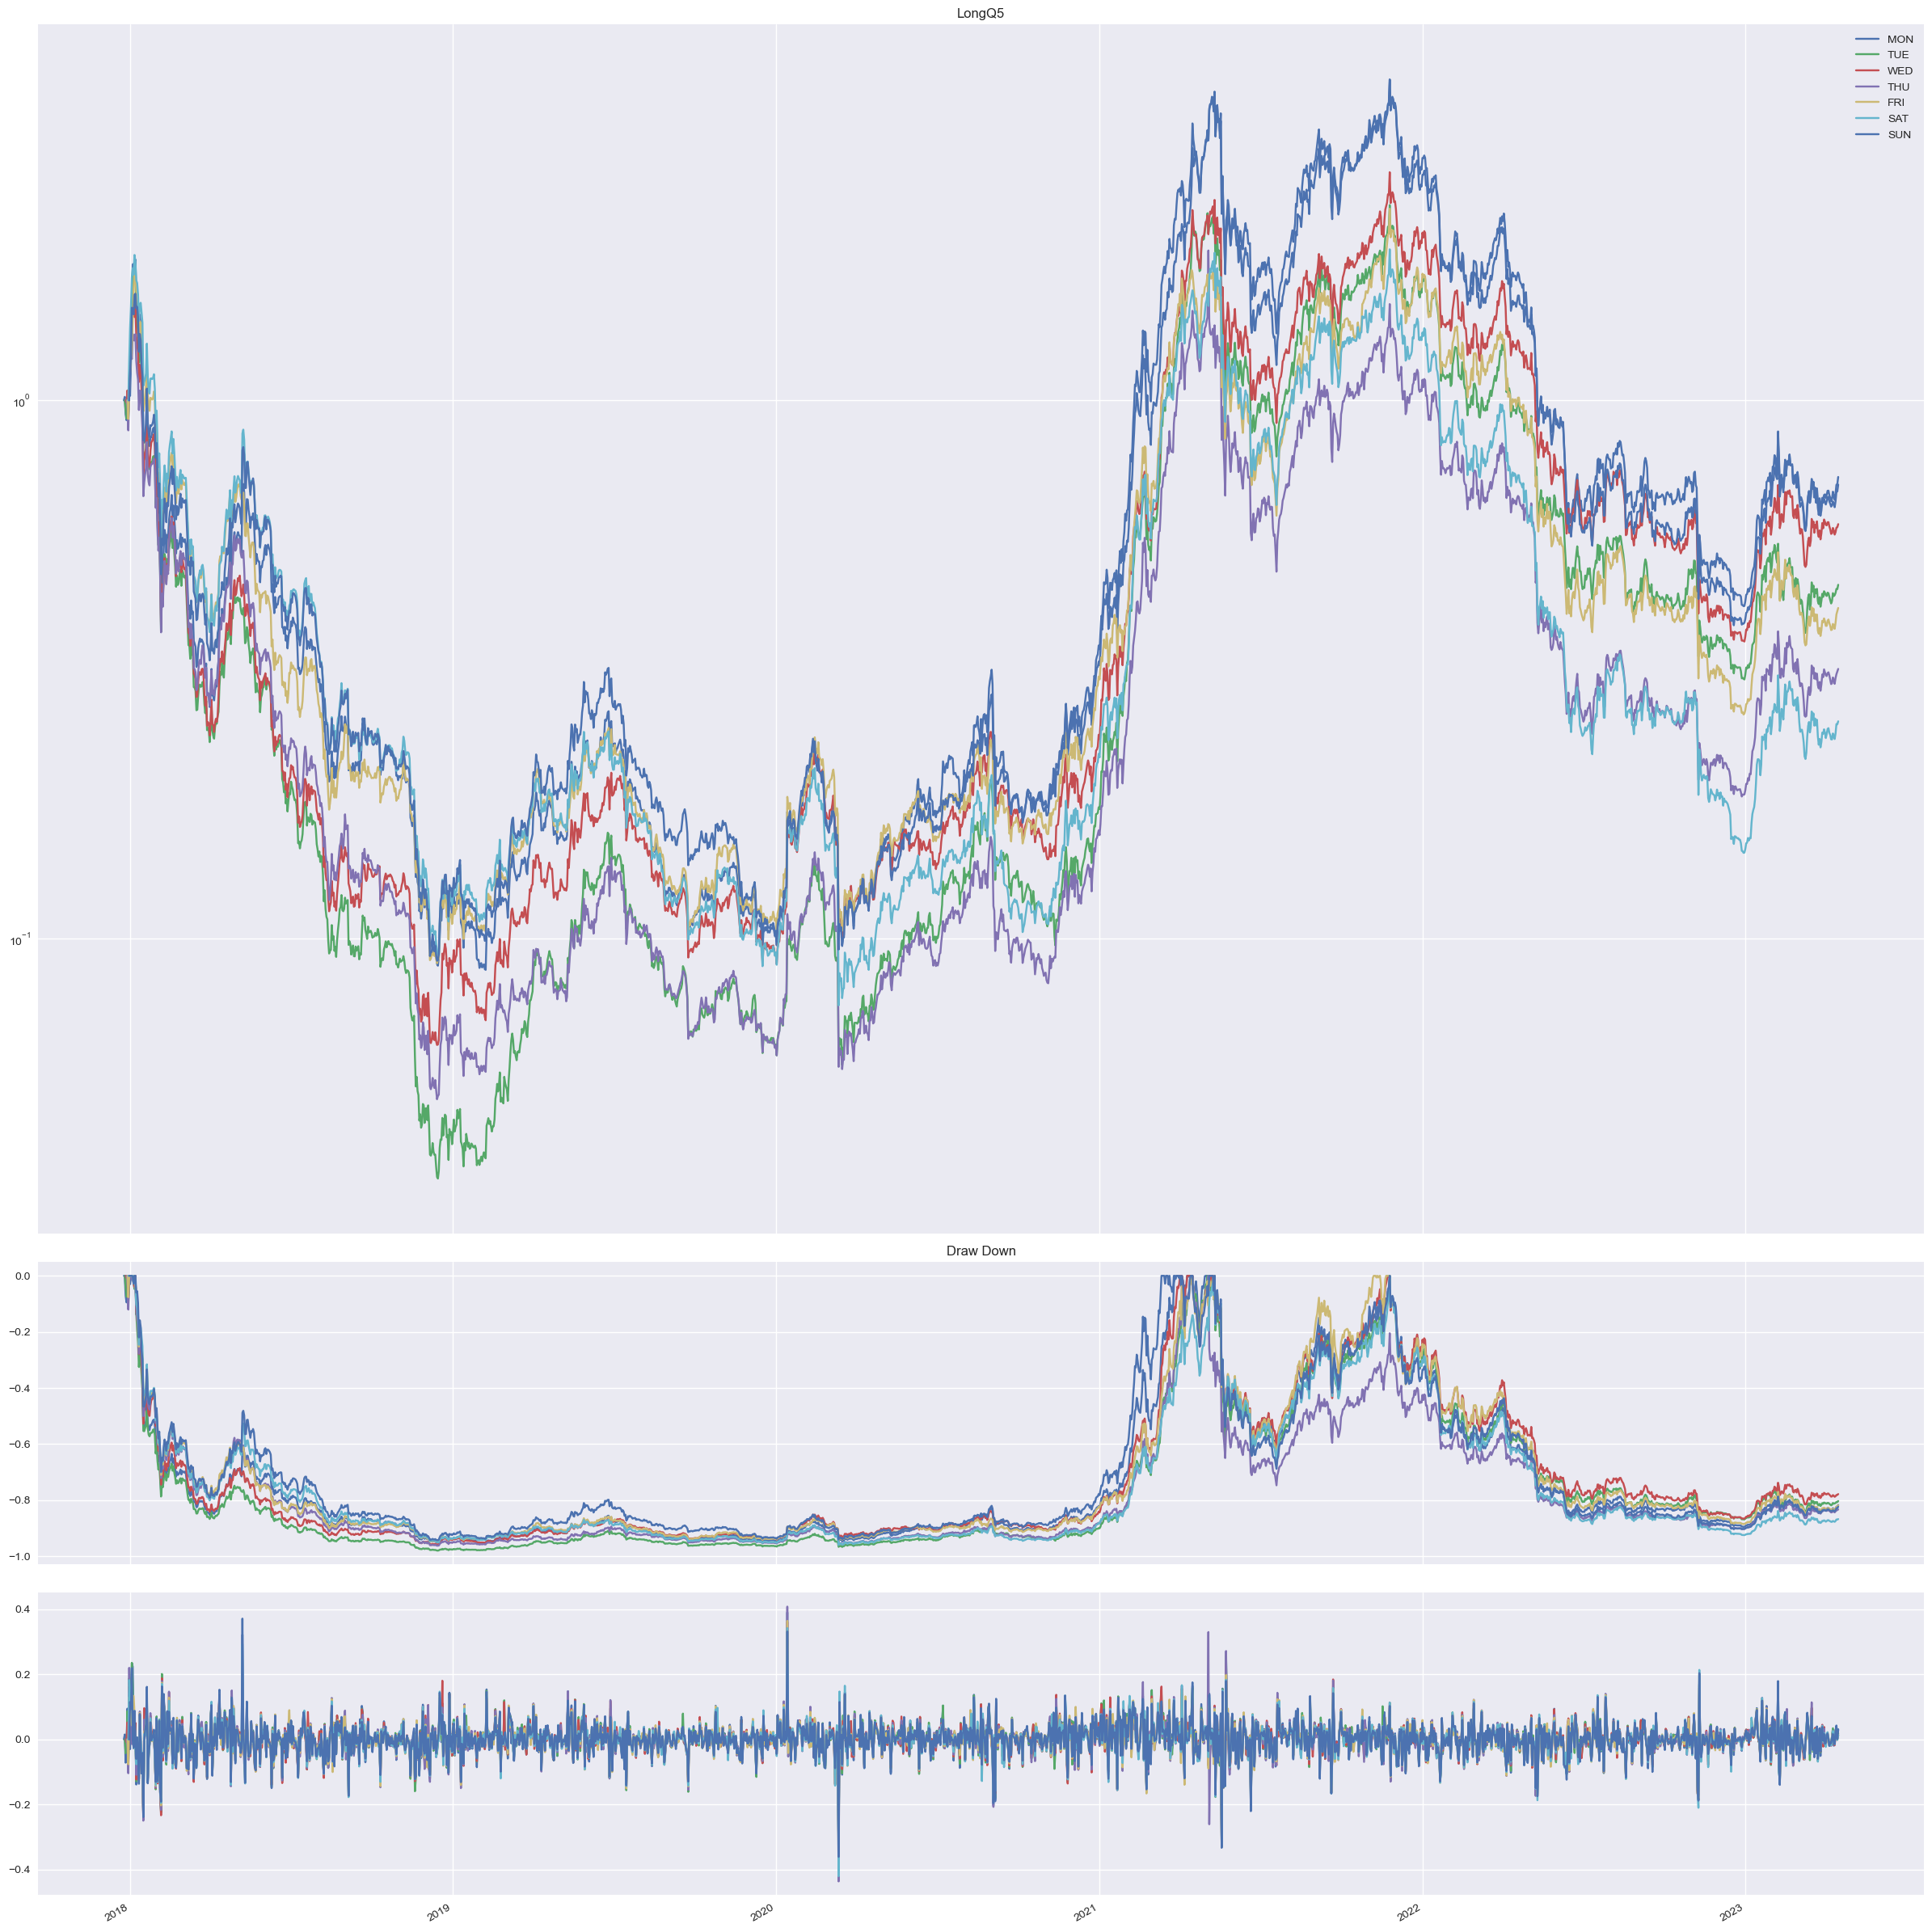

In [39]:
mytool.draw_return_result(ls, title=what,
                          log=True,
                          one_plot=True)

# 4. 모멘텀 전략 (Momentum Weighted) 

In [ ]:
momentum_weighted_cmkt = {}

momentum_weighted_future = [weekly_momentum_momentum_weighted.remote(price_df=ray_price,
                                                                   mktcap_df=ray_mktcap,
                                                                   vol_df=ray_vol,
                                                                   n_group=5,
                                                                   day_of_week="SUN",
                                                                   number_of_coin_group=20,
                                                                   mktcap_thresh=value_lst[0],
                                                                   vol_thresh=value_lst[1],
                                                                   fee_rate=0.0015) 
              for key, value_lst in group_value.items()]

momentum_weighted_result = ray.get(momentum_weighted_future)

In [ ]:
momentum_weighted_result_dict = {"M1":momentum_weighted_result[0],
                                 "M2":momentum_weighted_result[1],
                                 "M3":momentum_weighted_result[2],
                                 "M4":momentum_weighted_result[3]}

In [ ]:
mytool.draw_return_result(momentum_weighted_result_dict["M4"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_result_dict["M3"])

# 5. 모멘텀 전략 Weight Capped (Momentum Weighted) 

In [ ]:
momentum_weighted_capped_cmkt = {}

momentum_weighted_capped_future = [weekly_momentum_momentum_weighted_capped.remote(price_df=ray_price,
                                                                                   mktcap_df=ray_mktcap,
                                                                                   vol_df=ray_vol,
                                                                                   n_group=5,
                                                                                   day_of_week="SUN",
                                                                                   number_of_coin_group=20,
                                                                                   mktcap_thresh=value_lst[0],
                                                                                   vol_thresh=value_lst[1],
                                                                                   fee_rate=0.0015,
                                                                                   num_cap=5) 
              for key, value_lst in group_value.items()]

momentum_weighted_capped_result = ray.get(momentum_weighted_capped_future)

In [ ]:
momentum_weighted_capped_result_dict = {"M1":momentum_weighted_capped_result[0],
                                        "M2":momentum_weighted_capped_result[1],
                                        "M3":momentum_weighted_capped_result[2],
                                        "M4":momentum_weighted_capped_result[3]}

In [ ]:
mytool.draw_return_result(momentum_weighted_capped_result_dict["M4"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_capped_result_dict["M4"])